# Deep art classifier

Deep learning is taking over the world now, so I want to see what all this fuzz is about. I decided to dive in through the fast.ai [Practical Deep Learning for Coders](https://course.fast.ai/index.html) course. I am loving its right-to-the-point learn and code fast approach! 

The first lesson ends with the challenge of building a dataset with google images and train a deep learning classifier on them. I decided to do just that with paintings from different art periods. Here is how. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *

In [4]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [5]:
path = Path('paintings')

## Getting the data

I adapted [this notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) that explains how to use google images to build an image classifier dataset. After the first step you end up with a `.csv` file per classification class. In it, every line is a link to an image found by a google image query pointing to that class. In my case, I have 18 `.csv` files for art periods from early renaissance to pop-art with 300 links each.

Here we download all images linked from each `.csv` file. 

In [21]:
classes = []
for file in (path/'urls').ls():
    
    if file.name[-4:] == '.csv':
        cls = file.name[5:-4]
        classes.append(cls)
        dest = path/cls
        download_images(file, dest, max_pics=300)

Then we can remove any images that can't be opened:

In [23]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

How many images per class do we have at the end?

In [29]:
[(c.name, len(c.ls())) for c in path.ls()]

[('07-neoclassicism', 278),
 ('.ipynb_checkpoints', 0),
 ('13-expressionism', 288),
 ('02-high_renaissance', 294),
 ('10-impressionism', 286),
 ('14-cubism', 280),
 ('urls', 19),
 ('01-early_renaissance', 284),
 ('18-pop-art', 282),
 ('08-romanticism', 279),
 ('15-surrealism', 290),
 ('17-dadaism', 285),
 ('16-modernism', 283),
 ('06-rococo', 290),
 ('05-baroque', 287),
 ('09-realism', 274),
 ('12-fauvism', 283),
 ('03-northern_renaissance', 286),
 ('11-post-impressionism', 288),
 ('04-mannerism', 270)]

## View data

Let's take a look at a few examples from the dataset.

In [24]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

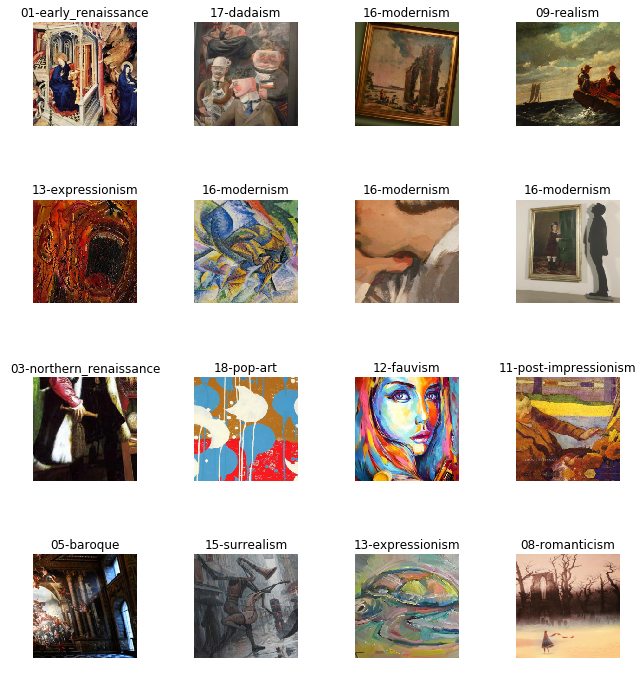

In [30]:
data.show_batch(rows=4, figsize=(9, 10))

Pretty cool, most images agree with my limited knowledge on the subject.

## Train first model

Now that we have the data, we will fit a convolutional neural network (CNN) model for classification in its 18 classes. We will start with a model pretrained on the [ImageNet](http://image-net.org/) dataset. 

The concept of starting out from a model trained in a different dataset and then modifying it to another one is called "transfer learning" (see more [at the fastai docs](https://docs.fast.ai/vision.learner.html#Transfer-learning)). From [here](https://www.kaggle.com/pytorch/resnet34):


```
What is a Pre-trained Model?
A pre-trained model has been previously trained on a dataset and contains the weights and biases that represent the features of whichever dataset it was trained on. Learned features are often transferable to different data. For example, a model trained on a large dataset of bird images will contain learned features like edges or horizontal lines that you would be transferable your dataset.

Why use a Pre-trained Model?
Pre-trained models are beneficial to us for many reasons. By using a pre-trained model you are saving time. Someone else has already spent the time and compute resources to learn a lot of features and your model will likely benefit from it.
```

From [fast.ai docs](https://docs.fast.ai/vision.learner.html#Transfer-learning):

```
Most convolutional models end with a few linear layers (a part we will call the head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (called the body or the backbone of the model) with their weights pretrained on ImageNet but will define a new head initialized randomly.

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possibly using differential learning rates).
```

Let's go.

In [32]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Train on the head.

In [33]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.611063,1.975113,0.620452,00:24
1,2.065905,1.811259,0.572271,00:24
2,1.790642,1.772887,0.564405,00:23
3,1.616325,1.769831,0.554572,00:24


In [34]:
learn.save('stage-1')

We save the results, then train also in the neural network body.

In [35]:
learn.unfreeze()

What is a good learning rate for this model and dataset?

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


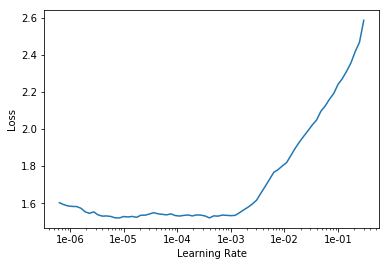

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.590089,1.716656,0.540806,00:28
1,1.342522,1.654692,0.517207,00:28


In [39]:
learn.save('stage-2')

Pretty decent for a first try I would say. 49% classification accuracy with a quickly built image dataset and model. In other words, half of the images in the validation set were assigned to the correct class out of a total of 18 classes. Let's see what we can interpret from the results and maybe we can improve them.

## Interpretation

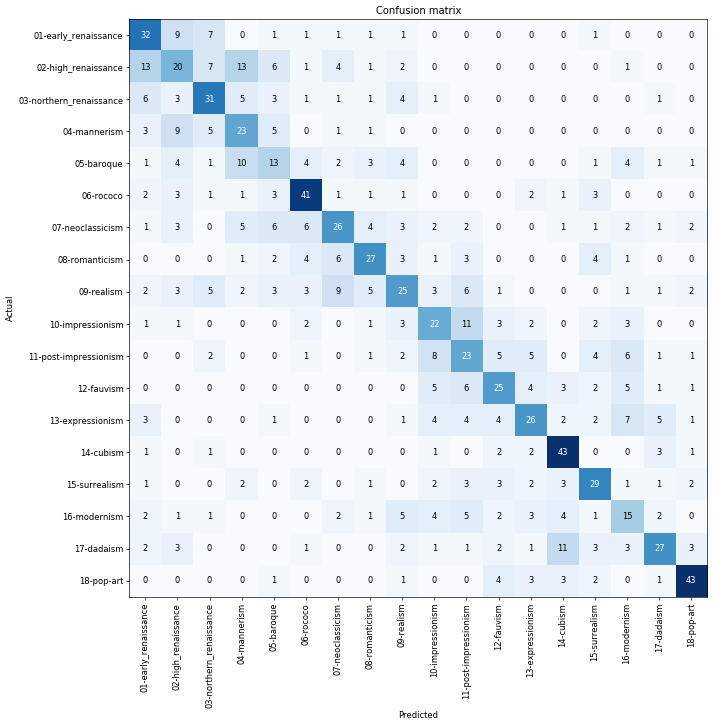

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interp.most_confused(min_val=7)

[('01-early_renaissance', '03-northern_renaissance', 15),
 ('11-post-impressionism', '10-impressionism', 13),
 ('07-neoclassicism', '05-baroque', 9),
 ('02-high_renaissance', '04-mannerism', 8),
 ('12-fauvism', '10-impressionism', 8),
 ('18-pop-art', '17-dadaism', 8),
 ('05-baroque', '04-mannerism', 7),
 ('09-realism', '08-romanticism', 7),
 ('13-expressionism', '12-fauvism', 7)]

I think this is very cool. Most mistakes occur close to the diagonal (see early, high and northern renaissance or impressionism and post-impressionism). This means that the model is picking up similarities among art periods that are very close in time. I imagine some examples are, for instance, in the verge of transition between early and high renaissance.

A few ideas on how to improve accuracy:

* More data.
* Clean data. Google images results are not perfect.
* Using resnet50.

I don't think the return on time investment of persuing these ideas will be worth it beyond this point though. It makes more sense to move on to fastai lesson 2. Stay tuned!